In [1]:
import os
import cv2
from PIL import Image
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import compute_unary, unary_from_softmax
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from imgaug import augmenters as iaa

Using TensorFlow backend.


In [2]:
seq = iaa.Sequential([
    iaa.SaltAndPepper(0.05)
])

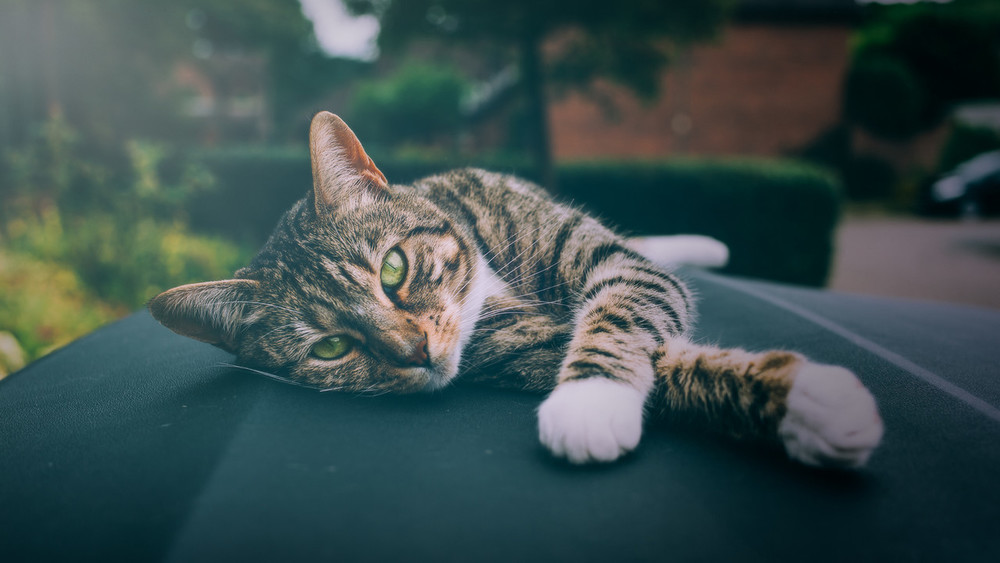

In [3]:
cat_path = os.path.join('docs', 'images', 'cat.jpg')
cat_bgr = cv2.imread(cat_path, 1)
cat_rgb = cv2.cvtColor(cat_bgr, cv2.COLOR_BGR2RGB)
display(Image.fromarray(cat_rgb))

In [4]:
print(cat_rgb.shape)

(563, 1000, 3)


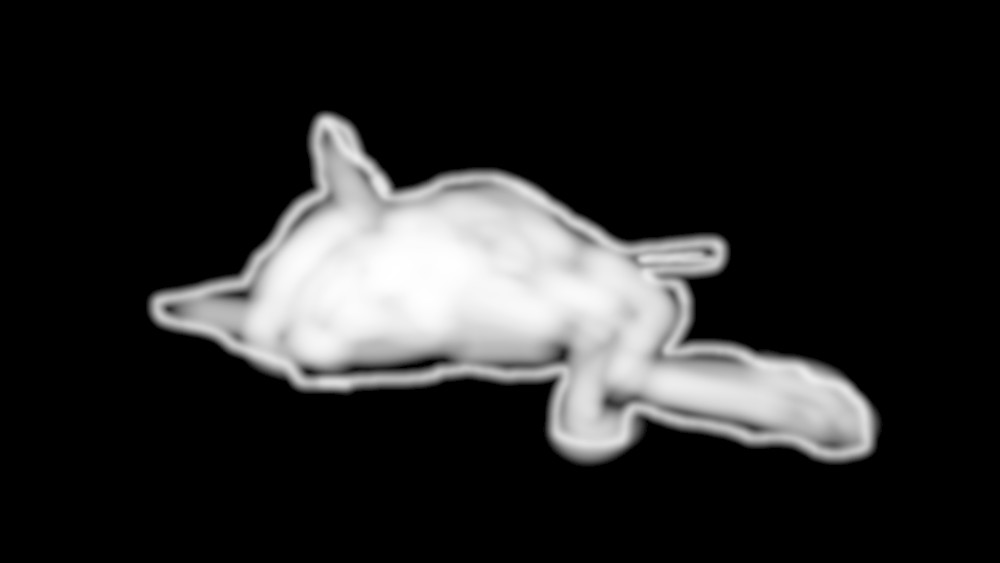

In [5]:
cat_mask_path = os.path.join('docs', 'images', 'cat_mask.jpg')
cat_mask = cv2.imread(cat_mask_path, 0)
#cat_mask = seq.augment_image(np.array(cat_mask, dtype=np.uint8))
display(Image.fromarray(cat_mask))

In [6]:
not_mask = cv2.bitwise_not(cat_mask)
not_mask = np.expand_dims(not_mask, axis=2)
cat_mask = np.expand_dims(cat_mask, axis=2)

In [7]:
im_softmax = np.concatenate([not_mask, cat_mask], axis=2)
im_softmax = im_softmax / 255.0
print(im_softmax.shape)

(563, 1000, 2)


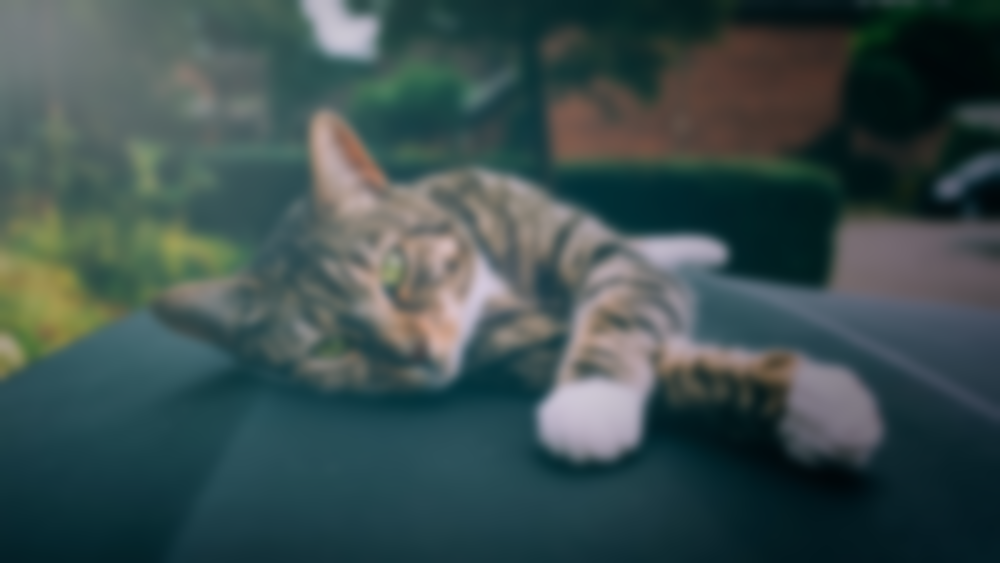

In [15]:
gauss_cat = cv2.GaussianBlur(cat_rgb, (31, 31), 0)
display(Image.fromarray(gauss_cat))

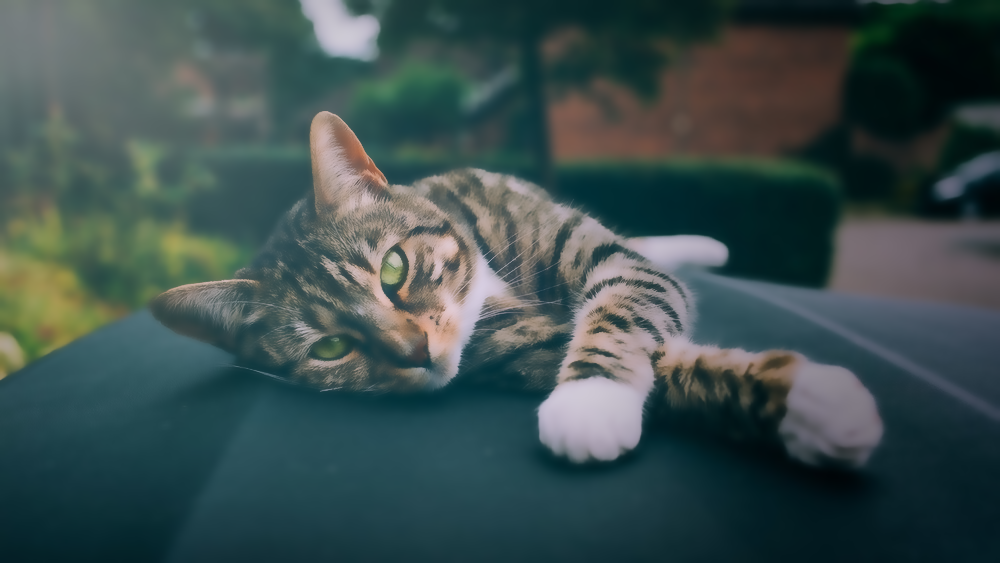

In [9]:
bilat_cat = cv2.bilateralFilter(cat_rgb, d=10, sigmaColor=80, sigmaSpace=80)
display(Image.fromarray(bilat_cat))

In [28]:
n_classes = 2
feat_first = im_softmax.transpose((2, 0, 1)).reshape((n_classes,-1))
print(feat_first.shape)
unary = unary_from_softmax(feat_first)
unary = np.ascontiguousarray(unary)

d = dcrf.DenseCRF2D(cat_rgb.shape[1], cat_rgb.shape[0], n_classes)

d.setUnaryEnergy(unary)
d.addPairwiseGaussian(sxy=(5, 5), compat=10, kernel=dcrf.DIAG_KERNEL,
                          normalization=dcrf.NORMALIZE_SYMMETRIC)

d.addPairwiseBilateral(sxy=(10, 10), srgb=(13, 13, 13), rgbim=cat_rgb,
                       compat=10,
                       kernel=dcrf.DIAG_KERNEL,
                       normalization=dcrf.NORMALIZE_SYMMETRIC)
Q = d.inference(5)
res = np.argmax(Q, axis=0).reshape((cat_rgb.shape[0], cat_rgb.shape[1]))
print(res.shape)

(2, 563000)
(563, 1000)


In [29]:
print(np.unique(res))
res_hot = to_categorical(res) * 255.0
print(res_hot.shape)

[0 1]
(563, 1000, 2)


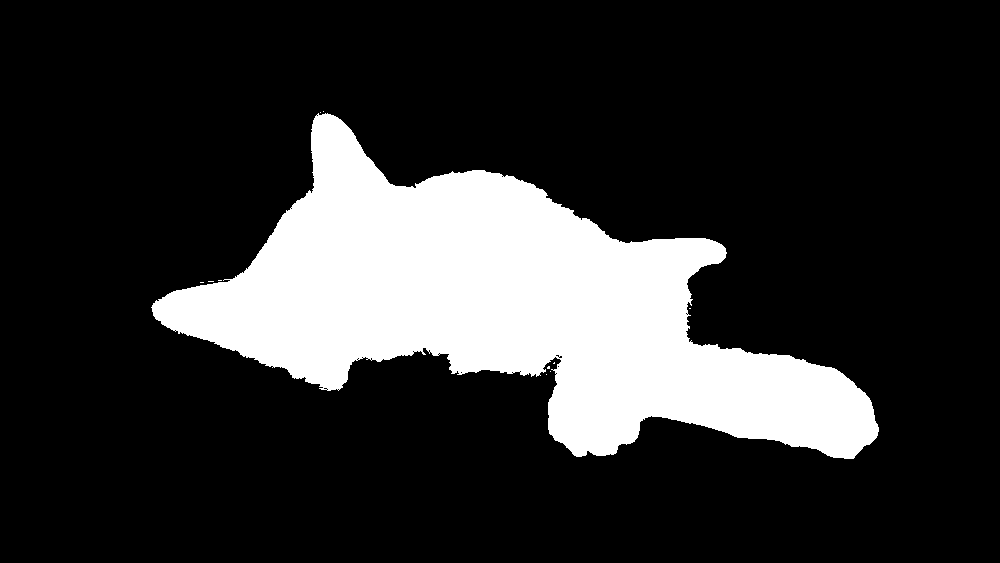

In [30]:
crf_mask = np.array(res*255, dtype=np.uint8)
display(Image.fromarray(crf_mask))

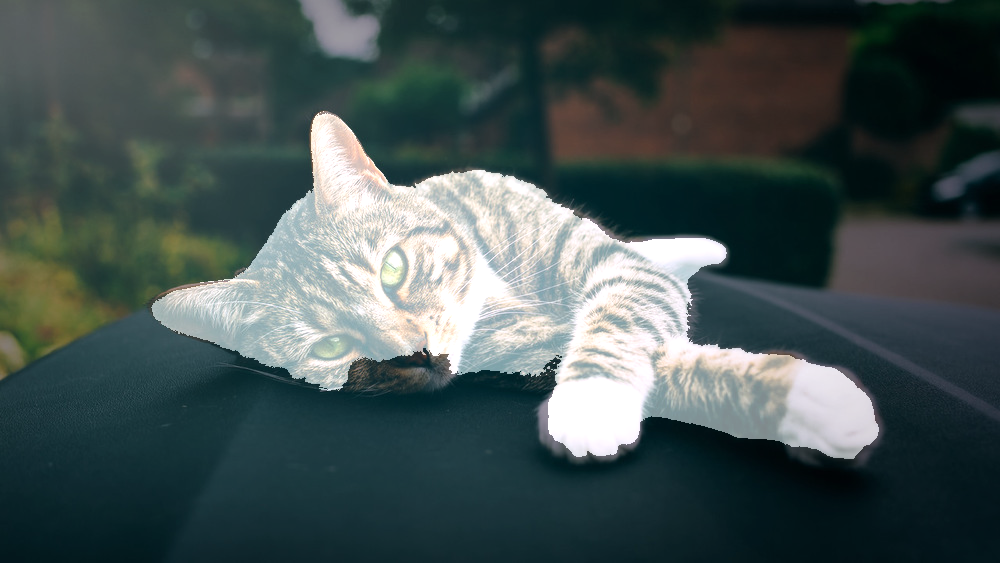

In [31]:
crf_rgb = cv2.cvtColor(crf_mask, cv2.COLOR_GRAY2RGB)
im = cv2.addWeighted(crf_rgb, 0.5, cat_rgb, 0.75, 0)
display(Image.fromarray(im))